In [ ]:
import numpy as np
import time
wheel_base = 90 #mm


#Constants
LEFT_WHEEL_VAR = 8.5
RIGHT_WHEEL_VAR = 10.9
ANGLE_VAR = 0.05
POSX_VAR = 5
POSY_VAR = 5.2

class ExtendedKalmanFilter:
    
    #how to initialize the matrices ???
    def __init__(self,x0=np.array([0,0,0,0,0])):
        #[position =(posx,posy),orientation,speed=(speed_left,spped_right)]
        self.x = x0
        
        #measurement matrix
        self.H_camera = np.eye(5)
        #measurement matrix without camera
        self.H_no_cam = np.array([[0,0,0,1,0],
                                  [0,0,0,0,1]])
       
        
        #set time
        self.set_time_t(time.time())
        #process noise covariance matrix 
        self.Q = np.diag([5*2, 5.2*2, 0.05*4, 8.5*4, 10.9*4]) 
        #self.Q = np.eye(5) 

        #measurement noise covariance matrix
        self.R_camera = np.diag([POSX_VAR, POSY_VAR, ANGLE_VAR, LEFT_WHEEL_VAR, RIGHT_WHEEL_VAR])  
  
        self.R_no_cam = np.diag([LEFT_WHEEL_VAR, RIGHT_WHEEL_VAR])  
        #initialize the state covariance matrix)
        self.P = self.Q
        
    def last_time_t(self):
        return self.t
    
    def set_time_t(self,t):
        self.t = t
        
    def state_transition_f(self,dt):
        angle = self.x[2]
        wheel_l = self.x[3]
        wheel_r = self.x[4]
        
        angular_velocity = (wheel_r - wheel_l)/wheel_base
        linear_velocity = (wheel_r + wheel_l)/2
        a_priori_estimate = np.array([
        self.x[0] + np.cos(angle) * linear_velocity * dt,  #posx
        self.x[1] + np.sin(angle) * linear_velocity * dt,  #posy
        self.x[2] + angular_velocity * dt,                #angle
        self.x[3],
        self.x[4]

    ])
        return a_priori_estimate
    
    def jacobian_f(self,dt):
        angle = self.x[2]
        wheel_l = self.x[3]
        wheel_r = self.x[4]
        
        #angular_velocity = (wheel_r - wheel_l)/wheel_base
        linear_velocity = (wheel_r + wheel_l)/2
        
        jacobian = np.array([
        [1, 0, np.sin(angle) * linear_velocity * dt, -0.5 * np.cos(angle) * dt, -0.5 * np.cos(angle) * dt],  #d(posx)/dx
        [0, 1,  np.cos(angle) * linear_velocity * dt, 0.5 * np.sin(angle) * dt, 0.5 * np.sin(angle) * dt],  #d(posy)/dy
        [0, 0, 1, -dt / (wheel_base), dt / (wheel_base)],  #d(angle)/dtheta (maybe divide by 2)
        [0, 0, 0, 1, 0],  
        [0, 0, 0, 0, 1]   
    ])
        return jacobian
        
        
        
        
    def predict(self,dt):
        #predict the state
        a_priori_x = self.state_transition_f(dt)
        #predict the state covariance matrix
        jacobian = self.jacobian_f(dt)
        a_priori_P = jacobian @ self.P @ jacobian.T + self.Q
        #make the angle between -pi and pi
        a_priori_x[2] = (a_priori_x[2] + np.pi) % (2 * np.pi) - np.pi
        self.x = a_priori_x
        self.P = a_priori_P
        return self.x,self.P
    

        
    def update(self,camera_on,z):
        if camera_on:
            #residual y = z - h(x) where z is the measurement
            #z = [posx,posy,angle,speed_left,speed_right]
            y = z -  self.x @ self.H_camera
            #residual covariance matrix
            S = self.H_camera @ self.P @ self.H_camera.T + self.R_camera
            #kalman gain
            K = self.P @ self.H_camera.T @ np.linalg.inv(S)
            #state update (a posteriori estimate)
            self.x = self.x + K @ y
            #state covariance update
            self.P = self.P - K @ self.H_camera @ self.P
        else:
            #residual y = z-h(x)
            #z = [speed_left,speed_right]
            y = z -  self.x @ self.H_no_cam
            #residual covariance matrix
            S = self.H_no_cam @ self.P @ self.H_no_cam.T + self.R_no_cam
            #kalman gain
            K = self.P @ self.H_no_cam.T @ np.linalg.inv(S)
            #state update
            self.x = self.x + K @ y
            #state covariance update
            self.P = self.P - K @ self.H_no_cam @ self.P
        #make the angle between -pi and pi
        self.x[2] = (self.x[2] + np.pi) % (2 * np.pi) - np.pi
        return self.x,self.P
        

  

    


In [654]:
import matplotlib.pyplot as plt

In [666]:
def apply_kalman(kalman: ExtendedKalmanFilter(np.array([0,0,0,0,0])),position=None,speed=None,dt=None):
    #if position is None/ [0,0,0] then camera is off:
    camera_on = position is not None
    if dt is None:
        dt = time.time() - kalman.last_time_t()
        kalman.set_time_t(time.time())
    if camera_on:
        z = np.array([position[0],position[1],position[2],speed[0],speed[1]])
    else:
        z = np.array([speed[0],speed[1]])
        
    #predict the state
    kalman.predict(dt)
    #update the state
    x,P = kalman.update(camera_on,z)
    
    return x,P
    
        

In [667]:
##test kalman filter with random data
dt = 0.1
#start position
start = np.array([0, 0, 0, 0, 0])
#trajectory of robot
left_wheel_speeds =  np.concatenate(([100]*10, [50]*10, [50]*10, [100]*10,[100]*10))
right_wheel_speeds = np.concatenate(([100]*10, [100]*10, [100]*10, [100]*10,[100]*10))

len_trajectory = len(left_wheel_speeds)

In [668]:
#transition function
def state_transition_f(x,dt):
        angle = x[2]
        wheel_l = x[3]
        wheel_r = x[4]
        
        angular_velocity = (wheel_r - wheel_l)/wheel_base
        linear_velocity = (wheel_r + wheel_l)/2
        a_priori_estimate = np.array([
        x[0] + np.cos(angle) * linear_velocity * dt,  #posx
        x[1] + np.sin(angle) * linear_velocity * dt,  #posy
        x[2] + angular_velocity * dt,                #angle
        x[3],
        x[4]   
    ])
        return a_priori_estimate
        

In [ ]:
#simulate ground truth position
pos = np.zeros((len_trajectory, 3))
#start at initial position
x_update = pos
for i in range(len_trajectory-1):
    #current state
    x_current = x_update
    x_current[3] = left_wheel_speeds[i]
    x_current[4] = right_wheel_speeds[i]
    #transition to next state
    x_update = state_transition_f(x_current, dt)
    
    pos[i+1] = x_update[0:3]

In [670]:
#add noises on the wheels
pos_wheel_noise = pos.copy()
left_speed_noise = [np.random.normal(speed, 8.5**0.5 )for speed in (left_wheel_speeds)]
right_speed_noise = [np.random.normal(speed, 10.9 **0.5)for speed in right_wheel_speeds]
#start at initial position
x_update = start
for i in range(len_trajectory-1):
    #current state
    x_current = x_update
    x_current[3] = left_speed_noise[i]
    x_current[4] = right_speed_noise[i]
    #transition to next state
    x_update = state_transition_f(x_current, dt)
    pos_wheel_noise[i+1] = [x_update[0],x_update[1],x_update[2]]

In [671]:
# do the kalman filter
pos_noise = pos.copy()

#add noise to x coordinate
pos_noise[1:, 0] = [np.random.normal(x, 5**0.5) for x in pos_noise[1:, 0]]
#add noise tp y coordinate
pos_noise[1:, 1] = [np.random.normal(y, 5.2**0.5) for y in pos_noise[1:, 1]]
#position given by kalman filter
position_kalman = np.zeros((len_trajectory, 3))
ekf = ExtendedKalmanFilter(start)
x_update = start
for i in range(len_trajectory):
    x_update, _ = apply_kalman(ekf, position = pos_noise[i], speed =np.array([left_speed_noise[i], right_speed_noise[i]]))
    position_kalman[i] =  [x_update[0],x_update[1],x_update[2]]

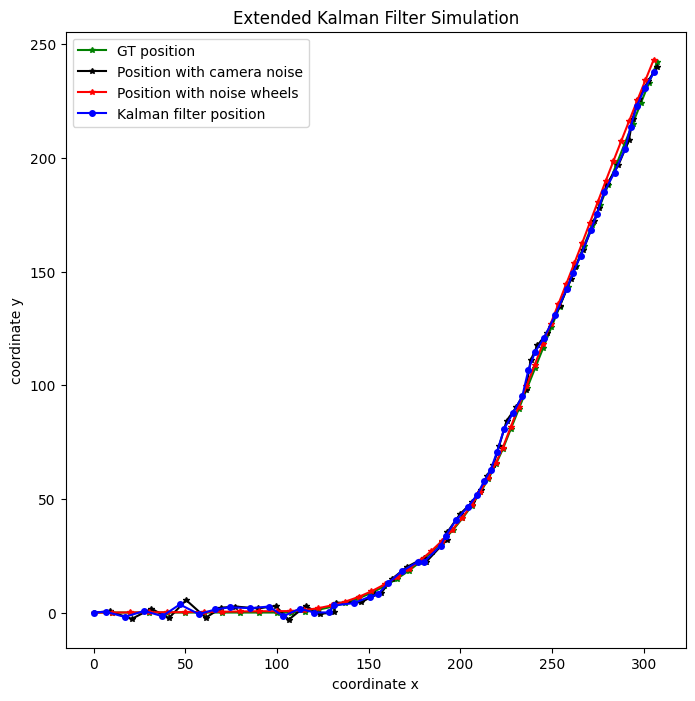

In [672]:
#plot the results
plt.figure(figsize=(8,8))
plt.plot(pos[:,0], pos[:,1], marker='*', markersize=4, color="green", label="GT position")
plt.plot(pos_noise[:,0], pos_noise[:,1], marker='*', markersize=4, color="black", label="Position with camera noise")
plt.plot(pos_wheel_noise[:,0], pos_wheel_noise[:,1], marker='*', markersize=4, color="red", label="Position with noise wheels")
plt.plot(position_kalman[:,0], position_kalman[:,1], marker='o', markersize=4, color="blue", label="Kalman filter position")

plt.xlabel("coordinate x")
plt.ylabel("coordinate y")
plt.title("Extended Kalman Filter Simulation")
plt.legend()